In [1]:
import os
import sys

In [2]:
sys.path.append("..")

In [3]:
import cv2
import numpy as np
import torch

In [4]:
from LookAround.FindView.sim import FindViewSim
from LookAround.FindView.rotation_tracker import RotationTracker

/home/ubuntu/.pyenv/versions/3.8.8/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Params:

Need to fix this later

In [5]:
img_path = "../data/sun360/indoor/bedroom/pano_afvwdfmjeaglsd.jpg"
initial_rots = {
    "roll": 0,
    "pitch": 0,
    "yaw": 0,
}
target_rots = {
    "roll": 0,
    "pitch": 1,
    "yaw": 1,
}

In [6]:
num_steps = 2000
dtype = torch.float32
height = 256
width = 256
fov = 90.0
sampling_mode = "bilinear"

Initialize simulator

In [7]:
sim = FindViewSim(
    height=height,
    width=width,
    fov=fov,
    sampling_mode=sampling_mode,
)
sim.inititialize_loader(
    dtype=dtype,
    device=torch.device('cpu'),
)
sim.load_episode(
    equi_path=img_path,
    initial_rotation=initial_rots,
    target_rotation=target_rots,
)
rot_tracker = RotationTracker(
    inc=1,
    pitch_threshold=60,
)
rot_tracker.reset(initial_rots)

NOTE: Using loading to cpu with index: None


Get perspective and target images

In [8]:
target = sim.render_target()
pers = sim.render_pers()

In [9]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

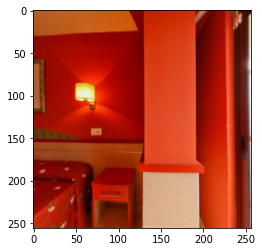

In [10]:
plt.imshow(cv2.cvtColor(pers, cv2.COLOR_BGR2RGB))

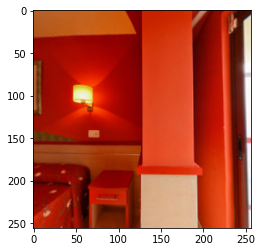

In [11]:
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

# Feature matching to active vision

In [12]:
gray_pers = cv2.cvtColor(pers, cv2.COLOR_BGR2GRAY)
gray_target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

In [13]:
sift_detector = cv2.SIFT_create()

In [15]:
(kps_pers, des_pers) = sift_detector.detectAndCompute(gray_pers, None)
(kps_target, des_target) = sift_detector.detectAndCompute(gray_target, None)

In [16]:
len(kps_pers)

92

In [17]:
len(kps_target)

94

In [18]:
kps_pers[0].pt

(9.742227554321289, 113.23555755615234)

In [19]:
kps = np.float32([kp.pt for kp in kps_pers])
# print(kps)

In [20]:
# change normType for detector
bf = cv2.BFMatcher(normType=cv2.NORM_L2, crossCheck=False)
matches = bf.match(des_pers, des_target)
matches = sorted(matches, key=lambda x: x.distance)
matches = matches[:10]

In [21]:
len(matches)

10

In [22]:
match_img = cv2.drawMatches(gray_pers, kps_pers, gray_target, kps_target, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

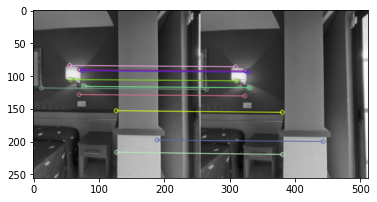

In [23]:
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))

In [24]:
# FIXME: are query and train, src and target?
pts_pers = np.float32([kps_pers[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts_target = np.float32([kps_target[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

In [25]:
M, mask = cv2.findHomography(pts_pers, pts_target, cv2.RANSAC, 5.0)

Homography matrix doesn't make sense...

In [26]:
M

array([[ 1.01851610e+00, -1.72951201e-02, -2.37627177e+00],
       [ 1.81311462e-02,  9.82774888e-01,  2.11597424e+00],
       [ 1.36408121e-04, -1.35983217e-04,  1.00000000e+00]])

In [27]:
actions = []

for m in matches:
    
    print(m.distance, m.queryIdx, m.trainIdx)
    if m.distance > 20:
        print(">>> far")
        continue
    
    # location in the perspective image
    print(kps_pers[m.queryIdx].pt)
    # locatin in the target image
    print(kps_target[m.trainIdx].pt)
    
    pers_loc = np.float32(kps_pers[m.queryIdx].pt)
    target_loc = np.float32(kps_target[m.trainIdx].pt)
    
    x_displacement = np.abs(pers_loc[0] - target_loc[0])
    y_displacement = np.abs(pers_loc[1] - target_loc[1])
        
    if 0 < x_displacement < 1 and 0 < y_displacement < 1:
        action = "stop"
    else:
        if x_displacement >= y_displacement:
            if pers_loc[0] > target_loc[0]:
                action = "right"
            elif pers_loc[0] < target_loc[0]:
                action = "left"
            else:
                print("this shouldn't occur...")
                action = "stop"
        elif x_displacement < y_displacement:
            if pers_loc[1] > target_loc[1]:
                action = "down"
            elif pers_loc[1] < target_loc[1]:
                action = "up"
            else:
                print("this shouldn't occur...")
                action = "stop"
        else:
            action = "stop"

    
    actions.append(action)

10.344079971313477 23 27
(55.45171356201172, 83.96128845214844)
(52.84333038330078, 85.9700698852539)
13.266499519348145 72 69
(189.24290466308594, 197.71270751953125)
(187.16871643066406, 199.94879150390625)
17.66352081298828 43 46
(70.89167022705078, 90.36602783203125)
(68.42012786865234, 92.47882843017578)
21.283796310424805 46 49
>>> far
21.97726058959961 47 50
>>> far
27.92848014831543 41 45
>>> far
31.984371185302734 65 65
>>> far
32.2180061340332 7 6
>>> far
33.941123962402344 67 66
>>> far
35.53871154785156 24 28
>>> far


In [28]:
actions

['right', 'up', 'right']

In [749]:
dst = cv2.warpPerspective(pers, M, (pers.shape[1], pers.shape[0]))

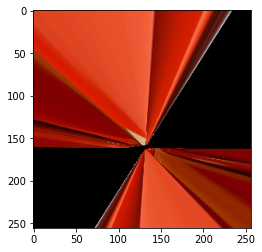

In [750]:
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))